In [19]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('dataset/clinvar_variants_all.csv')

After loading the data, let's peak at the features and some of their possible inputs

In [4]:
data.head()

,variation_id,gene_symbol,chrom,start_pos,end_pos,ref,alt,clinical_significance,review_status,phenotype_list
0,62,OPN1SW,7,128415610,128415610,C,T,Likely benign,"criteria provided, single submitter",Blue color blindness|not provided
1,62,OPN1SW,7,128775556,128775556,C,T,Likely benign,"criteria provided, single submitter",Blue color blindness|not provided
2,678,PROC,2,128176001,128176001,T,C,Pathogenic,no assertion criteria provided,"Thrombophilia due to protein C deficiency, aut..."
3,678,PROC,2,127418425,127418425,T,C,Pathogenic,no assertion criteria provided,"Thrombophilia due to protein C deficiency, aut..."
4,1515,PKLR,1,155271269,155271269,C,G,Pathogenic,no assertion criteria provided,Pyruvate kinase deficiency of red cells


In [5]:
data.describe()

,variation_id,start_pos,end_pos
count,1.056900e+04,1.056900e+04,1.056900e+04
mean,1.475947e+06,7.224351e+07,7.224351e+07
std,8.102180e+05,5.619225e+07,5.619225e+07
min,6.200000e+01,1.449400e+04,1.449400e+04
25%,1.198833e+06,2.960337e+07,2.960337e+07
50%,1.253672e+06,5.701780e+07,5.701780e+07
75%,1.327297e+06,1.088945e+08,1.088945e+08
max,4.281418e+06,2.485250e+08,2.485250e+08


A lot of our data is categorical, but here we can see 3 continuous values. Variation_id is just a label, so we can drop it, but start_pos and end_pos could have some correlation with our target variable. We'll investigate that later

# Target Value Distribution

<Axes: xlabel='clinical_significance', ylabel='count'>

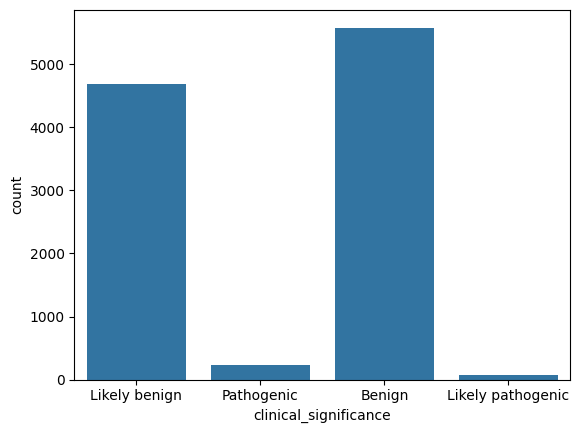

In [6]:
sns.countplot(x='clinical_significance', data=data)

<Axes: xlabel='clinical_significance', ylabel='proportion'>

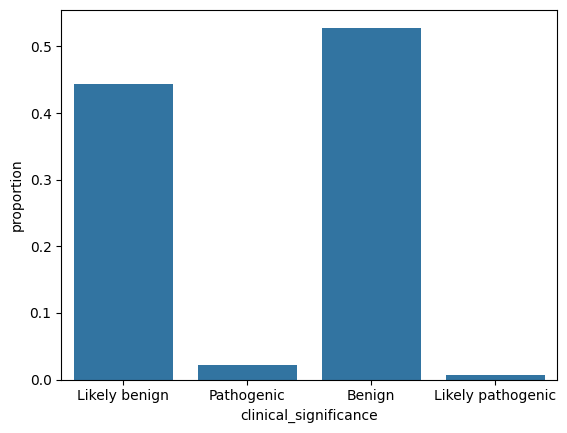

In [7]:
sns.countplot(x='clinical_significance', data=data, stat='proportion')

I'm going to combine the classes into just benign/pathogenic

In [11]:
classes = {'Likely benign': 0, 'Benign': 0, 'Pathogenic': 1, 'Likely pathogenic': 1}
data['target_class'] = data['clinical_significance'].map(classes)
data.head()

,variation_id,gene_symbol,chrom,start_pos,end_pos,ref,alt,clinical_significance,review_status,phenotype_list,target_class
0,62,OPN1SW,7,128415610,128415610,C,T,Likely benign,"criteria provided, single submitter",Blue color blindness|not provided,0
1,62,OPN1SW,7,128775556,128775556,C,T,Likely benign,"criteria provided, single submitter",Blue color blindness|not provided,0
2,678,PROC,2,128176001,128176001,T,C,Pathogenic,no assertion criteria provided,"Thrombophilia due to protein C deficiency, aut...",1
3,678,PROC,2,127418425,127418425,T,C,Pathogenic,no assertion criteria provided,"Thrombophilia due to protein C deficiency, aut...",1
4,1515,PKLR,1,155271269,155271269,C,G,Pathogenic,no assertion criteria provided,Pyruvate kinase deficiency of red cells,1


In [15]:
print(data['target_class'].value_counts())
print(data['target_class'].value_counts(normalize=True))

target_class
0    10266
1      303
Name: count, dtype: int64
target_class
0    0.971331
1    0.028669
Name: proportion, dtype: float64


We have a very heavy skew in our target class, with most of the data being likely benign or benign. Even if we never predict pathogenic we can still achieve 97% accuracy! This means we have to look closely at what kind of error we're getting.

I think to balance this, we can put a really heavy error false negatives. That is, if a piece of data is pathogenic but we classify it as benign or likely benign, we need to add a really large error term to make up for the lack of data. That way our model still learns to classify these terms correctly. 

Of course, the other problem is that we just don't have a lot of data that is pathogenic/likely pathogenic. Less than 70 entries are likely pathogenic, so it might be challenging for the model to learn what patterns correspond to this value. 

We should look at metrics other than accuracy, such as the precision and recall for each class. A confusion matrix will also be very helpful in our case

# Correlation Analysis

#### Now, let's see how each of our features relates to the target class

<Axes: xlabel='start_pos', ylabel='Count'>

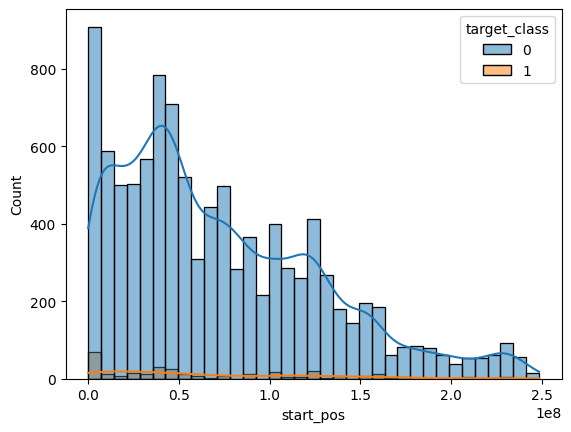

In [16]:
sns.histplot(data=data, x='start_pos', hue='target_class', kde=True)

<Axes: xlabel='start_pos'>

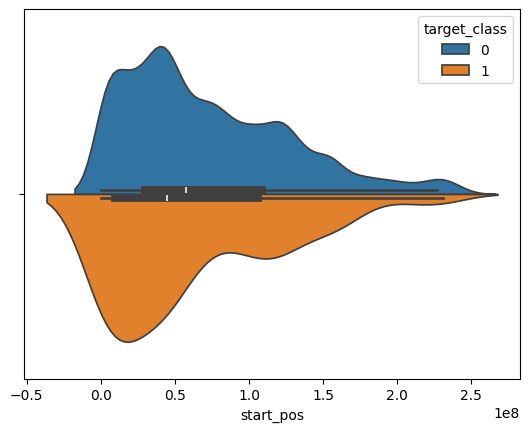

In [17]:
sns.violinplot(data=data, x='start_pos', hue='target_class', split=True)

Due to the lack of data for the pathogenic class, it's hard to make any conclusive statements about the relationship between start_pos and the target label. However, there does seem to be a slightly stronger skew for our pathogenic class, and the mean is a little more centered to the left.

<Axes: xlabel='ref', ylabel='proportion'>

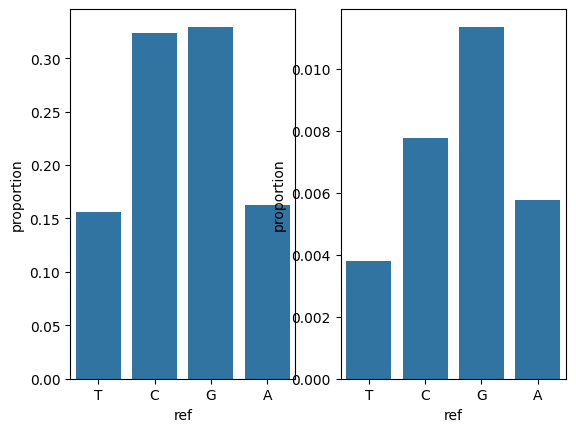

In [34]:
fig, axes=plt.subplots(1,2)
order = ('T','C','G','A')
sns.countplot(data=data.where(data['target_class'] == 0), x='ref', ax=axes[0], stat='proportion', order=order)
sns.countplot(data=data.where(data['target_class'] == 1), x='ref', ax=axes[1], stat='proportion', order=order)

<Axes: xlabel='alt', ylabel='proportion'>

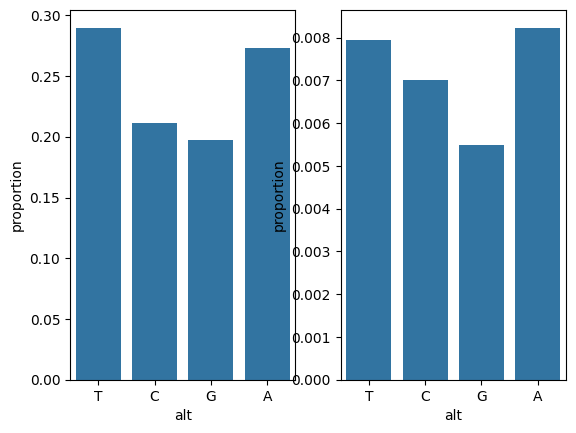

In [33]:
fig, axes=plt.subplots(1,2)
order = ('T','C','G','A')
sns.countplot(data=data.where(data['target_class'] == 0), x='alt', ax=axes[0], stat='proportion', order=order)
sns.countplot(data=data.where(data['target_class'] == 1), x='alt', ax=axes[1], stat='proportion', order=order)

The distribution, per class, of ref and alt looks somewhat similar so it might not be super indicative. But, I am curious to see if together these two features have any kind of correlation. I'm going to make a new feature that is the pair of these two, and plot that to see the counts per class.

In [36]:
data['ref_alt_pair'] = data['ref'] + data['alt']
data['ref_alt_pair']

0        CT
1        CT
2        TC
3        TC
4        CG
         ..
10564    GA
10565    CT
10566    CT
10567    TG
10568    TG
Name: ref_alt_pair, Length: 10569, dtype: object

<Axes: xlabel='ref_alt_pair', ylabel='proportion'>

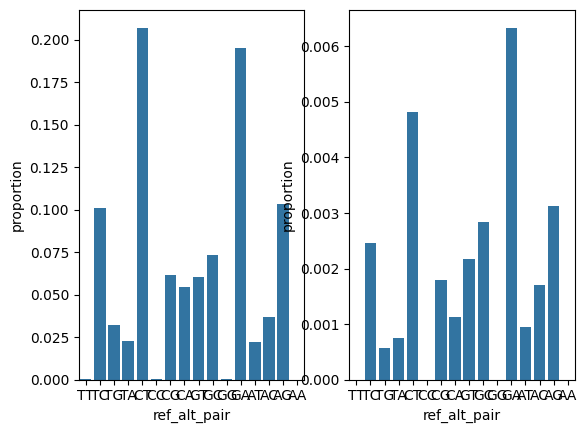

In [39]:
fig, axes=plt.subplots(1,2)
vals = ('T','C','G','A')
order = []
for ref in vals:
    for alt in vals:
        order.append(ref+alt)
sns.countplot(data=data.where(data['target_class'] == 0), x='ref_alt_pair', ax=axes[0], stat='proportion', order=order)
sns.countplot(data=data.where(data['target_class'] == 1), x='ref_alt_pair', ax=axes[1], stat='proportion', order=order)

<Axes: xlabel='ref_alt_pair'>

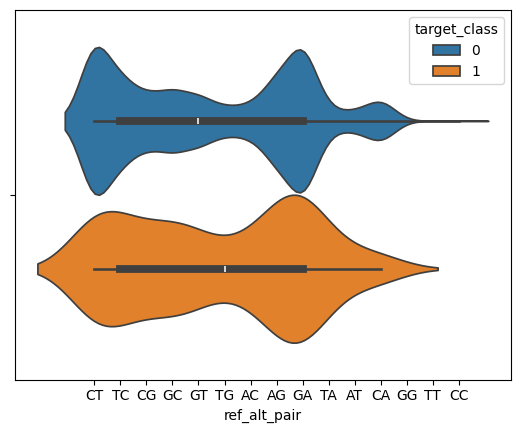

In [57]:
sns.violinplot(data=data, x='ref_alt_pair', hue='target_class')

It seems like there's some difference in distribution per class, but it's not super pronounced. Still, this could be useful. The mode, for example, is different, which hopefully implies a different underlying distribution and is not just due to the lack of data in pathogenic.

Next, I want to investigate the phenotype list feature.

In [42]:
data['phenotype_list'].describe()

count            10569
unique             622
top       not provided
freq              7806
Name: phenotype_list, dtype: object

In [43]:
data['phenotype_list'].value_counts()

phenotype_list
not provided                                                                        7806
not specified                                                                        308
Combined immunodeficiency due to ORAI1 deficiency;Myopathy, tubular aggregate, 2      86
Neuronal ceroid lipofuscinosis                                                        82
Myopathy, tubular aggregate, 2;Combined immunodeficiency due to ORAI1 deficiency      78
                                                                                    ... 
Neural tube defect                                                                     1
Primary ciliary dyskinesia 3                                                           1
Glycogen storage disease, type II                                                      1
Delayed puberty                                                                        1
Cleidocranial dysostosis                                                               1
Name: 

This feature is a little tricky because a lot of the data points don't have a list, and the ones that do seem to have unique values for every data point.

Finally, let's take a look at the chromosome

<Axes: xlabel='chrom', ylabel='count'>

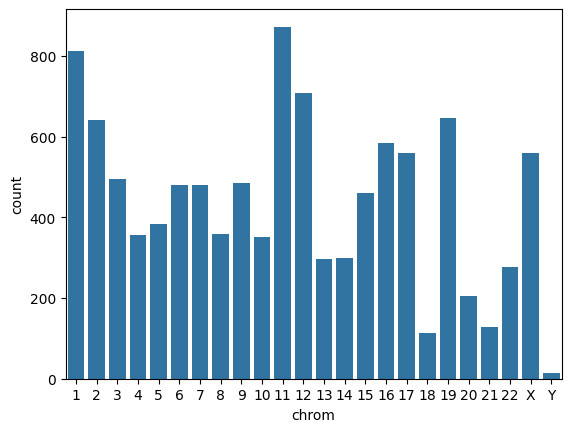

In [49]:
order = list(range(1,23))
order.extend(['X','Y'])
sns.countplot(data=data, x='chrom', order=order)

<Axes: xlabel='chrom'>

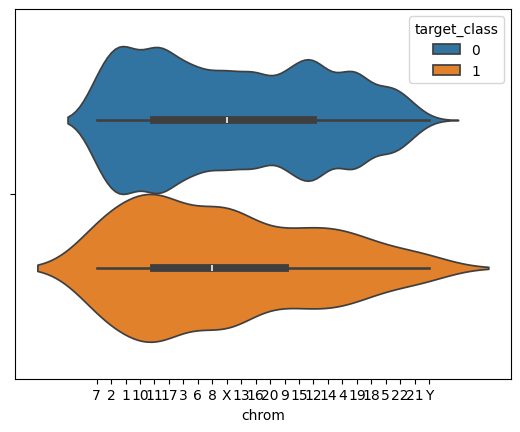

In [56]:
sns.violinplot(data=data, x='chrom', hue='target_class')

The distribution is different per class, again, which is great! This means the chromosome does have some significance on the pathogenic/benign nature. While it's not super pronounced, in conjunction with the other features, we might be able to get some strong predictive power.